# Setup

### Import libraries

In [76]:
import os
import csv
import cv2     
import shutil 
from tqdm import tqdm
from pathlib import Path
from IPython.core.magic import register_cell_magic

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import models, layers

from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Skip cell function

In [77]:
@register_cell_magic
def skip(line, cell):
    return

### Set GPU memory growth

In [78]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

### Prepare the dataset

In [79]:
data_dir = Path("BiNet_Dataset")
class_names = ['Corrosionstain', 'Cracks', 'Exposedbars', 'Spalling']

# Data Preprocessing

### Splitting the data

In [80]:
def split_data(data_dir, class_names, train_ratio=0.7, val_ratio=0.1, test_ratio=0.2):
    """
    Splits the data into training, validation, and testing sets.

    Parameters:
        data_dir: The directory of the data.
        class_names: List of class names.
        train_ratio: The ratio of the data to be used for training.
        val_ratio: The ratio of the data to be used for validation.
        test_ratio: The ratio of the data to be used for testing.
        
        Returns:
        PosixPath: The directory of training files.
        PosixPath: The directory of validation files.
        PosixPath: The directory of testing files.
    """

    # Create directories for training, validation, and testing sets
    train_dir = data_dir / "train/"
    val_dir = data_dir / "val/"
    test_dir = data_dir / "test/"

    # Create directories for each class in the training, validation, and testing folders
    for dir_path in [train_dir, val_dir, test_dir]:
        dir_path.mkdir(exist_ok=True, parents=True)

    # Iterate over each class
    for class_name in class_names:
        all_files = list((data_dir / class_name).glob("*.png"))
        np.random.shuffle(all_files)

        # Calculate the number of files for each set
        train_count = int(len(all_files) * train_ratio)
        val_count = int(len(all_files) * val_ratio)

        # Split the data into training, validation, and testing sets
        train_files = all_files[:train_count]
        val_files = all_files[train_count:train_count + val_count]
        test_files = all_files[train_count + val_count:]

        # Copy the files to the appropriate directories
        for subset, files in zip([train_dir, val_dir, test_dir], [train_files, val_files, test_files]):
            subset_class_dir = subset / class_name
            subset_class_dir.mkdir(exist_ok=True)
            for file in files:
                shutil.copy(file, subset_class_dir) 
    
    return train_dir, val_dir, test_dir      

In [81]:
%%skip
train_dir, val_dir, test_dir = split_data(data_dir, class_names)

In [82]:
train_dir = data_dir / "train/"
val_dir = data_dir / "val/"
test_dir = data_dir / "test/"

### Loading the data

In [83]:
def create_csv(dataset, class_names):
    """
    Creates a CSV file from the dataset and returns the path to the CSV file.

    Parameters:
        dataset: The directory of the dataset.
        class_names: List of class names.

    Returns:
        str: The path to the created CSV file.
    """
    
    data = []
    
    print("Loading {}".format(dataset))

    # Iterate through each folder
    for label in class_names:
        folder = label
        
        # Iterate through each image in our folder
        for file in tqdm(os.listdir(os.path.join(dataset, folder))):
            
            # Get the path name of the image
            img_path = os.path.join(dataset, folder, file)
            
            # Open the image and get its size
            image = cv2.imread(img_path)
            if image is not None:
                height, width, _ = image.shape
                size = f"{width}x{height}"
                
                # Append the image name, label, and size to the data list
                data.append([img_path, label, size])

    # Define the CSV file name
    csv_file_name = f"df_{os.path.basename(dataset)}.csv"
    
    # Open the file in write mode
    with open(csv_file_name, mode='w', newline='') as file:
        # Create a csv.writer object
        writer = csv.writer(file)
        
        # Write the header
        writer.writerow(['Image Path', 'Label', 'Image Size'])
        
        # Write data to the CSV file
        writer.writerows(data)
    
    print(f"CSV file saved to {csv_file_name}")
    
    return csv_file_name

### Create csv files from the datasets

In [84]:
%%skip
csv_train = create_csv(train_dir, class_names)
csv_val = create_csv(val_dir, class_names)
csv_test = create_csv(test_dir, class_names)

### Create DataFrames from the csv files

In [85]:
%%skip
df_train = pd.read_csv(csv_train)
df_val = pd.read_csv(csv_val)
df_test = pd.read_csv(csv_test)

# Combine the 3 DataFrames
combined_df = pd.concat([df_train, df_val, df_test])

In [86]:
df_train = pd.read_csv('df_train.csv')
df_val = pd.read_csv('df_val.csv')
df_test = pd.read_csv('df_test.csv')

# Combine the 3 DataFrames
combined_df = pd.concat([df_train, df_val, df_test])

### Data Exploration

##### Check the split ratio of the dataset

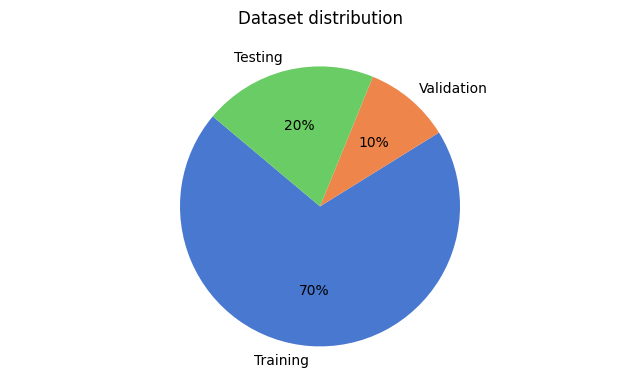

In [87]:
# Count the total number of images in each dataframe
train_count = len(df_train)
val_count = len(df_val)
test_count = len(df_test)

# Create a DataFrame to store the counts
data_counts = pd.DataFrame({
    'DataFrame': ['Training', 'Validation', 'Testing'],
    'Images': [train_count, val_count, test_count]
})

plt.figure(figsize=(8, 4))
plt.pie(data_counts['Images'], 
        labels=data_counts['DataFrame'],
        colors = sns.color_palette('muted')[0:5],
        autopct='%.0f%%', 
        startangle=140)
plt.title('Dataset distribution\n')
plt.axis('equal') 
plt.show()


The dataset seems to be properly distributed.

##### Check the class distribution

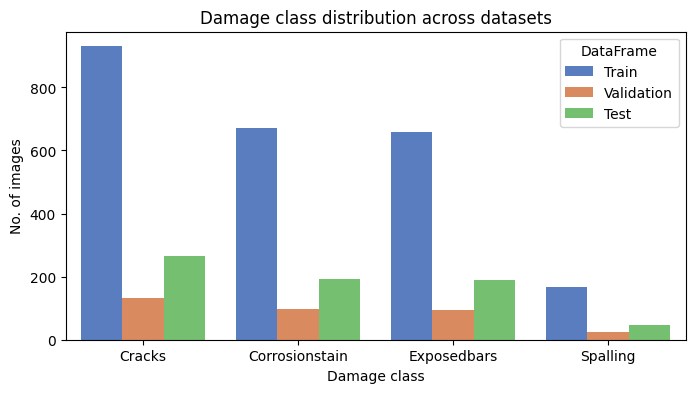

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count the occurrences of each label in each DataFrame
train_counts = df_train['Label'].value_counts()
val_counts = df_val['Label'].value_counts()
test_counts = df_test['Label'].value_counts()

# Create a DataFrame to hold the counts
label_counts_df = pd.DataFrame({
    'Label': train_counts.index,
    'Train': train_counts.values,
    'Validation': val_counts.values,
    'Test': test_counts.values
})

# Melt the DataFrame for Seaborn
label_counts_melted = label_counts_df.melt(id_vars='Label', var_name='DataFrame', value_name='Count')

plt.figure(figsize=(8, 4))
sns.barplot(data=label_counts_melted, x='Label', y='Count', hue='DataFrame', palette='muted')
plt.title('Damage class distribution across datasets')
plt.xlabel('Damage class')
plt.ylabel('No. of images')
plt.xticks(rotation=0)
plt.legend(title='DataFrame')
plt.show()

/tmp/ipykernel_20796/1458360760.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=label_distribution_df, x='Label', y='Images', palette='viridis')


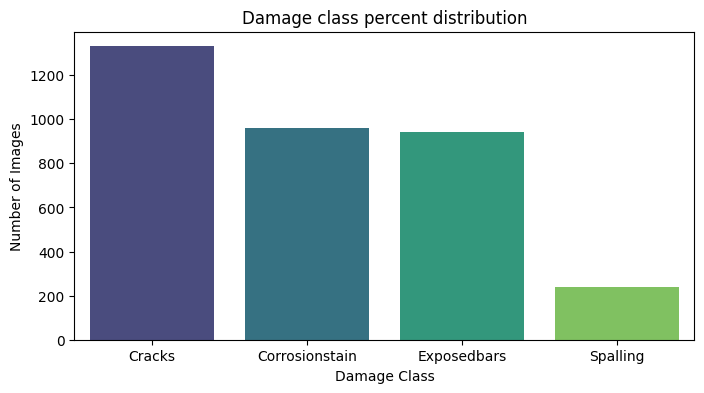

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count the occurrences of each label
label_distribution = combined_df['Label'].value_counts()

# Create a DataFrame for the bar chart
label_distribution_df = pd.DataFrame(label_distribution).reset_index()
label_distribution_df.columns = ['Label', 'Images']

plt.figure(figsize=(8, 4))
sns.barplot(data=label_distribution_df, x='Label', y='Images', palette='viridis')
plt.title('Damage class percent distribution')
plt.xlabel('Damage Class')
plt.ylabel('Number of Images')
plt.show()

Class imbalance is present. The imbalance will be addressed using weighted sampling.

##### Check image size variety

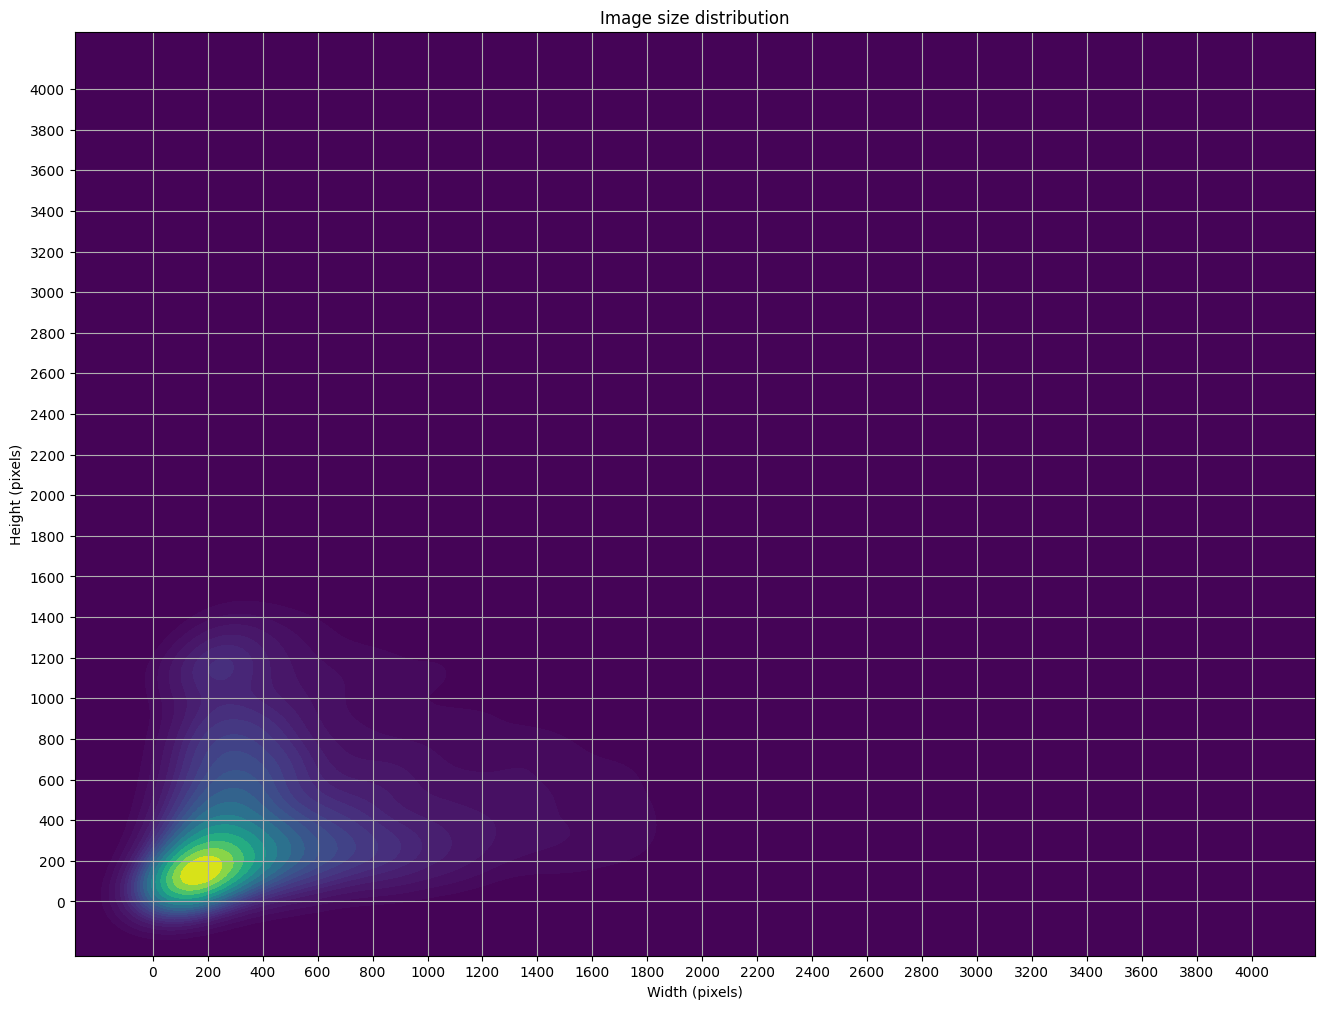

,Width,Height
count,3471.000000,3471.000000
mean,444.431000,438.699798
std,403.524937,388.013361
min,26.000000,32.000000
25%,179.000000,162.000000
50%,308.000000,314.000000
75%,562.500000,611.000000
max,3918.000000,3983.000000


In [90]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame for image sizes
img_size_df = pd.DataFrame(columns=['Width', 'Height'])
img_size_df[['Width', 'Height']] = combined_df['Image Size'].str.split('x', expand=True)

# Convert Width and Height to numeric
img_size_df["Width"] = pd.to_numeric(img_size_df["Width"])
img_size_df["Height"] = pd.to_numeric(img_size_df["Height"])

# Create a 2D KDE plot for Width and Height
plt.figure(figsize=(16, 12))
sns.kdeplot(data=img_size_df, x='Width', y='Height', fill=True, cmap='viridis', thresh=0, levels=20)
plt.title('Image size distribution')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')

tick_interval = 200

plt.xticks(ticks=range(0, int(img_size_df['Width'].max()) + tick_interval, tick_interval))
plt.yticks(ticks=range(0, int(img_size_df['Height'].max()) + tick_interval, tick_interval))
plt.grid(True)
plt.show()
img_size_df.describe()

The images vary in sizes, but most images seem to be at around 200x200 pixels.

### Create Generators

In [91]:
augment_gen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

In [92]:
train_gen = ImageDataGenerator(
    rescale=1.0/255,
    dtype='float32'  
)

val_gen = ImageDataGenerator(
    rescale=1.0/255,
    dtype='float32'  
)

test_gen = ImageDataGenerator(
    rescale=1.0/255,
    dtype='float32'  
)

In [93]:
IMG_WIDTH = IMG_HEIGHT = 128 #
BATCH_SIZE = 32 

train_generator = train_gen.flow_from_directory(
    train_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_gen.flow_from_directory(
    val_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_gen.flow_from_directory(
    test_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 2428 images belonging to 4 classes.
Found 347 images belonging to 4 classes.
Found 696 images belonging to 4 classes.


### Add Class Weights

Declare class weights to address the class imbalance

In [94]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

pd.DataFrame(list(class_weights.items()), columns=['Class', 'Weight'])

,Class,Weight
0,0,0.903274
1,1,0.652688
2,2,0.922492
3,3,3.613095


### Check generator images

In [95]:
def plot_sample_images(generator, class_labels):
    images, labels = next(generator)
    plt.figure(figsize=(12, 8))
    for i in range(12):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        plt.title(class_labels[np.argmax(labels[i])])
        plt.axis('off')
    plt.show()

class_labels = list(train_generator.class_indices.keys())

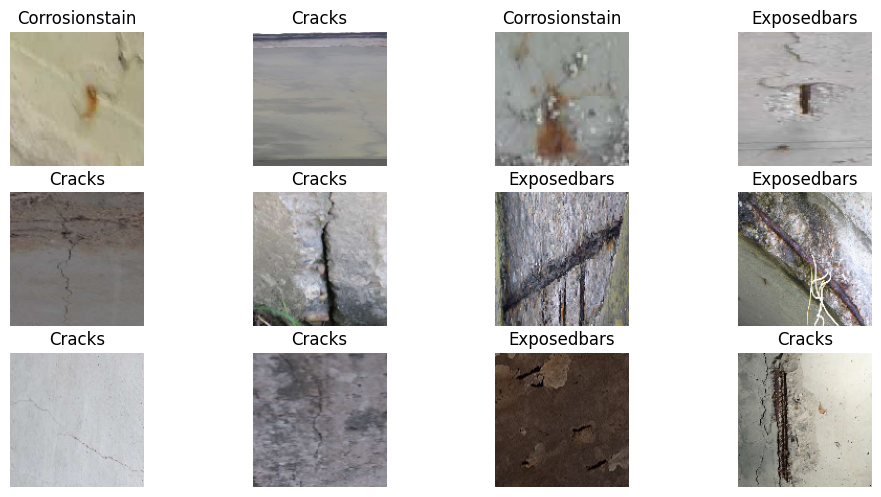

In [96]:
plot_sample_images(train_generator, class_labels)

# CNN Model Experiments

### Trial 1

##### Model Creation

In [69]:
model_uno = models.Sequential()
model_uno.add(layers.InputLayer(shape=(IMG_WIDTH, IMG_HEIGHT, 3))) 

model_uno.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_uno.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_uno.add(layers.Flatten())

model_uno.add(layers.Dense(128, activation='relu'))
model_uno.add(layers.Dense(len(class_names), activation='softmax'))  

model_uno.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

##### Model fitting

In [98]:
model_uno_hist = model_uno.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weights
)

Epoch 1/10


/home/arbovitae/miniconda3/envs/tf218/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-12-14 00:25:04.604953: W tensorflow/core/framework/op_kernel.cc:1829] INVALID_ARGUMENT: TypeError: `generator` yielded an element that did not match the expected structure. The expected structure was (tf.float32, tf.float32, tf.float32), but the yielded element was (array([[[[0.22352943, 0.21960786, 0.20000002],
         [0.227451  , 0.227451  , 0.19607845],
         [0.23137257, 0.227451  , 0.20784315],
         ...,
         [0.2509804 , 0.2392157 , 0.17254902],
         [0.2509804 , 0.2392157 , 0.16470589],
         [0.2509804 , 0.2392157 , 0.17254902]],

        [[0.22352943, 0.2196078

InvalidArgumentError: Graph execution error:

2 root error(s) found.
  (0) INVALID_ARGUMENT:  TypeError: `generator` yielded an element that did not match the expected structure. The expected structure was (tf.float32, tf.float32, tf.float32), but the yielded element was (array([[[[0.22352943, 0.21960786, 0.20000002],
         [0.227451  , 0.227451  , 0.19607845],
         [0.23137257, 0.227451  , 0.20784315],
         ...,
         [0.2509804 , 0.2392157 , 0.17254902],
         [0.2509804 , 0.2392157 , 0.16470589],
         [0.2509804 , 0.2392157 , 0.17254902]],

        [[0.22352943, 0.21960786, 0.20000002],
         [0.227451  , 0.227451  , 0.19607845],
         [0.23137257, 0.227451  , 0.20784315],
         ...,
         [0.2509804 , 0.2392157 , 0.17254902],
         [0.2509804 , 0.2392157 , 0.16470589],
         [0.2509804 , 0.2392157 , 0.17254902]],

        [[0.10588236, 0.10980393, 0.09019608],
         [0.10980393, 0.1137255 , 0.09411766],
         [0.1137255 , 0.11764707, 0.09803922],
         ...,
         [0.27058825, 0.2627451 , 0.20392159],
         [0.27058825, 0.26666668, 0.19607845],
         [0.27058825, 0.2627451 , 0.20392159]],

        ...,

        [[0.03529412, 0.03529412, 0.03529412],
         [0.03529412, 0.03529412, 0.03529412],
         [0.03529412, 0.03529412, 0.03529412],
         ...,
         [0.05490196, 0.05882353, 0.03921569],
         [0.05490196, 0.05882353, 0.03921569],
         [0.05490196, 0.05882353, 0.03921569]],

        [[0.03529412, 0.03529412, 0.03529412],
         [0.03529412, 0.03529412, 0.03529412],
         [0.03529412, 0.03529412, 0.03529412],
         ...,
         [0.05490196, 0.05882353, 0.03921569],
         [0.05490196, 0.05882353, 0.03921569],
         [0.05490196, 0.05882353, 0.03921569]],

        [[0.03529412, 0.03529412, 0.03529412],
         [0.03529412, 0.03529412, 0.03529412],
         [0.03529412, 0.03529412, 0.03529412],
         ...,
         [0.05490196, 0.05882353, 0.03921569],
         [0.05490196, 0.05882353, 0.03921569],
         [0.05490196, 0.05882353, 0.03921569]]],


       [[[0.6431373 , 0.5686275 , 0.41176474],
         [0.6431373 , 0.5686275 , 0.41176474],
         [0.6431373 , 0.5686275 , 0.41176474],
         ...,
         [0.627451  , 0.5529412 , 0.39607847],
         [0.627451  , 0.5529412 , 0.39607847],
         [0.627451  , 0.5529412 , 0.39607847]],

        [[0.6431373 , 0.5686275 , 0.41176474],
         [0.6431373 , 0.5686275 , 0.41176474],
         [0.6431373 , 0.5686275 , 0.41176474],
         ...,
         [0.627451  , 0.5529412 , 0.39607847],
         [0.627451  , 0.5529412 , 0.39607847],
         [0.627451  , 0.5529412 , 0.39607847]],

        [[0.6392157 , 0.5647059 , 0.40784317],
         [0.6392157 , 0.5647059 , 0.40784317],
         [0.6392157 , 0.5647059 , 0.40784317],
         ...,
         [0.627451  , 0.5529412 , 0.39607847],
         [0.627451  , 0.5529412 , 0.39607847],
         [0.62352943, 0.54901963, 0.3921569 ]],

        ...,

        [[0.5686275 , 0.49411768, 0.3372549 ],
         [0.57254905, 0.49803925, 0.34117648],
         [0.5764706 , 0.5019608 , 0.34509805],
         ...,
         [0.47058827, 0.40784317, 0.20784315],
         [0.54509807, 0.47450984, 0.2784314 ],
         [0.50980395, 0.43137258, 0.23529413]],

        [[0.5686275 , 0.49411768, 0.3372549 ],
         [0.5686275 , 0.49411768, 0.3372549 ],
         [0.57254905, 0.49803925, 0.34117648],
         ...,
         [0.5019608 , 0.43137258, 0.23529413],
         [0.58431375, 0.5137255 , 0.31764707],
         [0.50980395, 0.43137258, 0.23529413]],

        [[0.5686275 , 0.49411768, 0.3372549 ],
         [0.5686275 , 0.49411768, 0.3372549 ],
         [0.57254905, 0.49803925, 0.34117648],
         ...,
         [0.5019608 , 0.43137258, 0.23529413],
         [0.58431375, 0.5137255 , 0.31764707],
         [0.50980395, 0.43137258, 0.23529413]]],


       [[[0.54509807, 0.54509807, 0.43529415],
         [0.49411768, 0.49411768, 0.38431376],
         [0.50980395, 0.50980395, 0.40000004],
         ...,
         [0.3137255 , 0.3254902 , 0.2509804 ],
         [0.31764707, 0.32941177, 0.25490198],
         [0.32156864, 0.33333334, 0.25882354]],

        [[0.5019608 , 0.5019608 , 0.3921569 ],
         [0.5019608 , 0.5019608 , 0.3921569 ],
         [0.5058824 , 0.5058824 , 0.39607847],
         ...,
         [0.3137255 , 0.3254902 , 0.2509804 ],
         [0.32156864, 0.33333334, 0.25882354],
         [0.3372549 , 0.34901962, 0.27450982]],

        [[0.5176471 , 0.5176471 , 0.40784317],
         [0.5176471 , 0.5176471 , 0.40784317],
         [0.5137255 , 0.5137255 , 0.4039216 ],
         ...,
         [0.32156864, 0.33333334, 0.25882354],
         [0.3254902 , 0.3372549 , 0.2627451 ],
         [0.32941177, 0.34117648, 0.26666668]],

        ...,

        [[0.2627451 , 0.2627451 , 0.2627451 ],
         [0.4666667 , 0.4666667 , 0.4666667 ],
         [0.427451  , 0.427451  , 0.41960788],
         ...,
         [0.5137255 , 0.5176471 , 0.3921569 ],
         [0.5058824 , 0.50980395, 0.38431376],
         [0.5254902 , 0.5294118 , 0.4039216 ]],

        [[0.32156864, 0.32156864, 0.32156864],
         [0.30588236, 0.30588236, 0.30588236],
         [0.36078432, 0.36078432, 0.3529412 ],
         ...,
         [0.48627454, 0.4901961 , 0.3647059 ],
         [0.4901961 , 0.49411768, 0.36862746],
         [0.5058824 , 0.50980395, 0.38431376]],

        [[0.15686275, 0.16078432, 0.14117648],
         [0.28627452, 0.28627452, 0.2784314 ],
         [0.29411766, 0.29411766, 0.28627452],
         ...,
         [0.5529412 , 0.5568628 , 0.43137258],
         [0.56078434, 0.5647059 , 0.43921572],
         [0.5686275 , 0.57254905, 0.44705886]]],


       ...,


       [[[0.7686275 , 0.75294125, 0.7411765 ],
         [0.7490196 , 0.73333335, 0.72156864],
         [0.7411765 , 0.7254902 , 0.7137255 ],
         ...,
         [0.7686275 , 0.7960785 , 0.8352942 ],
         [0.7725491 , 0.8000001 , 0.83921576],
         [0.7607844 , 0.78823537, 0.82745105]],

        [[0.7372549 , 0.7254902 , 0.69803923],
         [0.76470596, 0.7490196 , 0.7372549 ],
         [0.76470596, 0.7490196 , 0.75294125],
         ...,
         [0.7568628 , 0.7843138 , 0.8235295 ],
         [0.7686275 , 0.7960785 , 0.8352942 ],
         [0.7686275 , 0.7960785 , 0.8352942 ]],

        [[0.69803923, 0.6862745 , 0.65882355],
         [0.75294125, 0.7372549 , 0.7254902 ],
         [0.7294118 , 0.70980394, 0.7254902 ],
         ...,
         [0.76470596, 0.79215693, 0.8313726 ],
         [0.77647066, 0.80392164, 0.8431373 ],
         [0.77647066, 0.80392164, 0.8431373 ]],

        ...,

        [[0.7294118 , 0.73333335, 0.7137255 ],
         [0.7372549 , 0.7411765 , 0.72156864],
         [0.75294125, 0.7568628 , 0.7372549 ],
         ...,
         [0.74509805, 0.7490196 , 0.7294118 ],
         [0.7372549 , 0.7411765 , 0.72156864],
         [0.7372549 , 0.7411765 , 0.72156864]],

        [[0.75294125, 0.7568628 , 0.7254902 ],
         [0.73333335, 0.7372549 , 0.7058824 ],
         [0.74509805, 0.7490196 , 0.7176471 ],
         ...,
         [0.75294125, 0.7411765 , 0.7137255 ],
         [0.7411765 , 0.7294118 , 0.7019608 ],
         [0.7411765 , 0.7294118 , 0.7019608 ]],

        [[0.75294125, 0.7411765 , 0.7137255 ],
         [0.75294125, 0.7411765 , 0.7137255 ],
         [0.7019608 , 0.6901961 , 0.6627451 ],
         ...,
         [0.7411765 , 0.7294118 , 0.7019608 ],
         [0.73333335, 0.72156864, 0.69411767],
         [0.7490196 , 0.7372549 , 0.70980394]]],


       [[[0.83921576, 0.82745105, 0.8078432 ],
         [0.8470589 , 0.8352942 , 0.81568635],
         [0.8470589 , 0.8352942 , 0.81568635],
         ...,
         [0.8196079 , 0.82745105, 0.7843138 ],
         [0.8196079 , 0.82745105, 0.7843138 ],
         [0.8196079 , 0.8235295 , 0.79215693]],

        [[0.8470589 , 0.8352942 , 0.81568635],
         [0.85098046, 0.83921576, 0.8196079 ],
         [0.85098046, 0.83921576, 0.8196079 ],
         ...,
         [0.8313726 , 0.83921576, 0.7960785 ],
         [0.8313726 , 0.83921576, 0.7960785 ],
         [0.8313726 , 0.8352942 , 0.80392164]],

        [[0.8352942 , 0.8235295 , 0.80392164],
         [0.8313726 , 0.8196079 , 0 [Op:__inference_multi_step_on_iterator_1435]

2024-12-14 00:25:04.991489: W tensorflow/core/framework/op_kernel.cc:1829] INVALID_ARGUMENT: TypeError: `generator` yielded an element that did not match the expected structure. The expected structure was (tf.float32, tf.float32, tf.float32), but the yielded element was (array([[[[0.90196085, 0.8470589 , 0.73333335],
         [0.90196085, 0.8470589 , 0.73333335],
         [0.9058824 , 0.85098046, 0.7372549 ],
         ...,
         [0.8470589 , 0.7843138 , 0.5803922 ],
         [0.8352942 , 0.7568628 , 0.5568628 ],
         [0.89019614, 0.8117648 , 0.6156863 ]],

        [[0.90196085, 0.8470589 , 0.73333335],
         [0.90196085, 0.8470589 , 0.73333335],
         [0.90196085, 0.8470589 , 0.73333335],
         ...,
         [0.8470589 , 0.7843138 , 0.5803922 ],
         [0.8313726 , 0.75294125, 0.5529412 ],
         [0.9215687 , 0.8431373 , 0.64705884]],

        [[0.8862746 , 0.854902  , 0.7137255 ],
         [0.8862746 , 0.854902  , 0.7137255 ],
         [0.9058824 , 0.854902  , 0.72